Evaluate models trained on rigid docking and tested on flexible docking.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import os

In [2]:
annotation=""
prefix="nc"

flexroot="../../cd-downsampled/"
flexanalysis=os.path.join(flexroot, "analysis")

In [3]:
# Load dataframe for SMINA on FLEXIBLE docking
# Note: SMINA performance on flexible docking is lower than smina performance on rigid docking
dfname = os.path.join(flexanalysis, f"{annotation}{prefix}_annotated.csv")
df = pd.read_csv(dfname)
df

,pocket,protein,ligand,rank,rmsd,obrmsd,flexobrmsd,fmaxrmsd,score,group,annotation
0,ABL1,1FPU,3QRK,0,1.12474,1.12474,0.75627,1.09286,-11.82862,1,1
1,ABL1,1FPU,3QRK,10,7.46179,7.46179,1.38199,2.77094,-11.55337,1,0
2,ABL1,1FPU,3QRK,11,8.08863,8.08863,1.44861,2.51482,-11.47044,1,0
3,ABL1,1FPU,3QRK,12,8.47072,8.47072,1.60736,2.34249,-11.35890,1,0
4,ABL1,1FPU,3QRK,13,8.45633,8.45633,1.61014,2.35856,-11.32845,1,0
...,...,...,...,...,...,...,...,...,...,...,...
165586,XIAP,5C84,4KMP,5,9.60539,9.60539,1.43189,2.28256,-7.57331,63,0
165587,XIAP,5C84,4KMP,6,8.41238,8.41238,1.30168,2.39061,-7.51172,63,0
165588,XIAP,5C84,4KMP,7,6.88340,6.88340,0.95547,1.40152,-7.40088,63,0
165589,XIAP,5C84,4KMP,8,5.19961,5.19961,2.08915,2.97329,-7.32203,63,0


In [4]:
def load_scores(df, model, annotation, prefix):
    score = pd.concat((
    pd.read_csv(f"../training/{annotation}/{model}/FLEX{annotation}{prefix}test0.out", sep=" ", header=None),
    pd.read_csv(f"../training/{annotation}/{model}/FLEX{annotation}{prefix}test1.out", sep=" ", header=None),
    pd.read_csv(f"../training/{annotation}/{model}/FLEX{annotation}{prefix}test2.out", sep=" ", header=None),
    ))
    
    if prefix == "nc":
        # No affinity column
        to_drop = [1,2,3,5,6,7]
    elif prefix == "cluster":
        to_drop = [1,2,3,5,6,7,8]

    
    score.drop(columns=to_drop, inplace=True)
    score.rename(columns={0: "CNNscore", 4: "ligname"}, inplace=True)
    score.dropna(inplace=True) # Last row contains NaN (it is  actually a comment)

    #print(score)

    def getid(row):
        # Use ligand name which contains both protein and ligand names
        # Protein name does not contain the ligand name for rigid docking
        namesplit = row["ligname"].split("/")

        pocket = namesplit[1]

        split = namesplit[-1].split("_")

        protein = split[0]
        ligand = split[2]

        rank = int(split[-1][1:].replace(".gninatypes", ""))

        return (pocket, protein, ligand, rank)

    score[["pocket", "protein", "ligand", "rank"]] = score.apply(getid, axis=1, result_type="expand")
    score.drop(columns="ligname", inplace=True)

    df_score = df.merge(score, on=["pocket", "protein", "ligand", "rank"])

    return df_score

In [5]:
def topN(df, nmax):

    n_pockets = 0
    
    # Store top N metrics
    top_smina = [0] * nmax
    top_gnina = [0] * nmax
    top_best = [0] * nmax

    # Loop over pockets
    for _, group in df.groupby(by=["pocket"]):
        n_smina = [0] * nmax
        n_gnina = [0] * nmax
        n_best = [0] * nmax

        # Compute percentage of targets with good pose in top N
        n_targets = 0
        for _, tgroup in group.groupby("protein"):
            smina = tgroup.sort_values(by="score", ascending=True)
            gnina = tgroup.sort_values(by="CNNscore", ascending=False)
            best = tgroup.sort_values(by="rmsd", ascending=True)

            for n in range(1, nmax + 1):
                # At least one good pose amongst the top N
                if (smina["annotation"].iloc[:n] == 1).any():
                    n_smina[n-1] += 1

                if (gnina["annotation"].iloc[:n] == 1).any():
                    n_gnina[n-1] += 1
                
                if (best["annotation"].iloc[:n] == 1).any():
                    n_best[n-1] += 1

            n_targets += 1

        # Accumulate results for all targets
        for n in range(1, nmax + 1):
            top_smina[n-1] += n_smina[n-1] / n_targets * 100
            top_gnina[n-1] += n_gnina[n-1]  / n_targets * 100
            top_best[n-1] += n_best[n-1]  / n_targets * 100

        n_pockets += 1

    # One pocket has been removed from the training set
    # for lack of actives
    assert n_pockets == 91

    # Return TopN of targets, averaged per pocket
    top_smina_avg = np.array(top_smina) / n_pockets
    top_gnina_avg = np.array(top_gnina) / n_pockets
    top_best_avg =  np.array(top_best) / n_pockets
    return np.array([list(range(1,nmax+1)), top_smina_avg, top_gnina_avg, top_best_avg]).T

In [6]:
nmax = 10

In [7]:
for model in ["default2017", "default2018", "dense"]:
    if prefix == "nc":
        modelname = f"{model}-noaffinity-nostratified"
    elif prefix == "cluster":
        modelname = f"{model}-noaffinity"

    df_score = load_scores(df, modelname, annotation, prefix)

    for crystal in ["", "nocrystal_"]:
        if crystal == "":
            t  = topN(df_score, nmax)
        elif crystal == "nocrystal_":
            # Remove crystal
            t = topN(df_score[df_score["rank"] != 0], nmax)
        else:
            raise Exception

        df_top = pd.DataFrame(t, columns=["N", "smina", "gnina", "best"])
        df_top.to_csv(f"TopN/{crystal}{modelname}_{annotation}.csv", index=None)

In [8]:
crystal_nostratified = pd.concat(
    (
        pd.read_csv(f"TopN/default2017-noaffinity-nostratified_{annotation}.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv(f"TopN/default2018-noaffinity-nostratified_{annotation}.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv(f"TopN/dense-noaffinity-nostratified_{annotation}.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
crystal_nostratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,31.730625,60.880491,92.928415,59.033158,61.748881
2.0,41.028493,73.196439,92.928415,71.382261,73.688144
3.0,47.046652,79.654103,92.928415,77.206062,78.379549
4.0,50.156765,82.811453,92.928415,80.111374,82.212452
5.0,54.230891,85.049292,92.928415,82.438650,84.905017
6.0,57.103549,86.576741,92.928415,83.595383,86.401431
7.0,59.010673,87.601171,92.928415,85.064882,87.463711
8.0,62.412560,88.538952,92.928415,85.948874,88.305613
9.0,64.008278,89.265141,92.928415,86.606938,88.936276


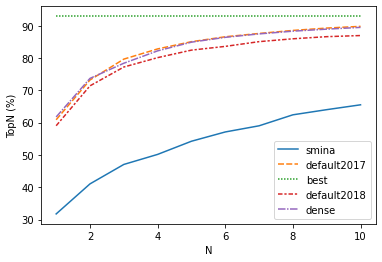

In [9]:
sns.lineplot(data=crystal_nostratified)
plt.ylabel("TopN (%)")
plt.savefig("plots/TopN-crystal-nostratified.pdf")
plt.savefig("plots/TopN-crystal-nostratified.png")

In [10]:
#crystal_stratified = pd.concat(
#    (
#        pd.read_csv("TopN/default2017-noaffinity.csv",index_col=0).rename(columns={"gnina": "default2017"}),
#        pd.read_csv("TopN/default2018-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
#        pd.read_csv("TopN/dense-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
#    ),
#    axis=1,
#)
#crystal_stratified

In [11]:
#sns.lineplot(data=crystal_stratified)
#plt.ylabel("TopN (%)")
#plt.ylim([25,100])
#plt.savefig("plots/TopN-crystal-stratified.pdf")
#plt.savefig("plots/TopN-crystal-stratified.png")

In [12]:
nocrystal_nostratified = pd.concat(
    (
        pd.read_csv(f"TopN/nocrystal_default2017-noaffinity-nostratified_{annotation}.csv",index_col=0).rename(columns={"gnina": "default2017"}),
        pd.read_csv(f"TopN/nocrystal_default2018-noaffinity-nostratified_{annotation}.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
        pd.read_csv(f"TopN/nocrystal_dense-noaffinity-nostratified_{annotation}.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
    ),
    axis=1,
)
nocrystal_nostratified

,smina,default2017,best,default2018,dense
N,,,,,
1.0,28.201177,39.468730,74.790018,38.220608,39.248585
2.0,36.782877,49.578228,74.790018,48.573430,49.850746
3.0,42.380985,55.481567,74.790018,54.554386,55.141348
4.0,45.076304,59.382201,74.790018,58.583202,59.342833
5.0,48.092379,61.669239,74.790018,61.499838,62.685390
6.0,50.264707,63.584035,74.790018,62.971114,64.670527
7.0,51.823790,65.135388,74.790018,64.452574,66.063966
8.0,53.401534,66.716801,74.790018,65.660338,67.082823
9.0,54.553835,68.079225,74.790018,66.437077,68.453583


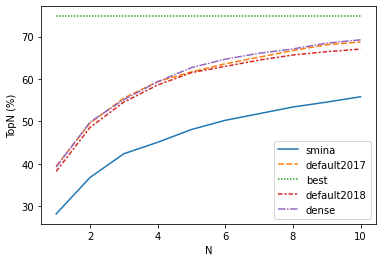

In [13]:
sns.lineplot(data=nocrystal_nostratified)
plt.ylabel("TopN (%)")
plt.savefig("plots/TopN-nocrystal-nostratified.pdf")
plt.savefig("plots/TopN-nocrystal-nostratified.png")

In [14]:
#nocrystal_stratified = pd.concat(
#    (
#        pd.read_csv("TopN/nocrystal_default2017-noaffinity.csv",index_col=0).rename(columns={"gnina": "default2017"}),
#        pd.read_csv("TopN/nocrystal_default2018-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "default2018"}),
#        pd.read_csv("TopN/nocrystal_dense-noaffinity.csv",index_col=0).drop(columns=["smina", "best"]).rename(columns={"gnina": "dense"}),
#    ),
#    axis=1,
#)
#nocrystal_stratified

In [15]:
#sns.lineplot(data=nocrystal_stratified)
#plt.ylabel("TopN (%)")
#plt.ylim([25,100])
#plt.savefig("plots/TopN-nocrystal-stratified.pdf")
#plt.savefig("plots/TopN-nocrystal-stratified.png")